In [1]:
import jax
import numpy as np
import correctionlib
import matplotlib.pyplot as plt

In [2]:
import correctionlib.schemav2 as cs

x = np.array([10., 20., 30., 40., 50., 80., 120.])
y = np.array([1.1, 1.08, 1.06, 1.04, 1.02, 1.0])
ptweight = cs.Correction(
    name="ptweight",
    version=1,
    inputs=[cs.Variable(name="pt", type="real", description="Muon transverse momentum")],
    output=cs.Variable(name="weight", type="real", description="Multiplicative event weight"),
    data=cs.Binning(
        nodetype="binning",
        input="pt",
        edges=list(x),
        content=list(y),
        flow="clamp",
    ),
).to_evaluator()

In [3]:
from scipy.interpolate import CubicSpline

def midpoints(x):
    return 0.5*(x[1:] + x[:-1])

spline = CubicSpline(midpoints(x), y, bc_type="clamped")

def clip_input(pt):
    # so that extrapolation works
    return np.clip(pt, spline.x[0], spline.x[-1])

@jax.custom_vjp
def ptweight_spline(pt):
    return spline(clip_input(pt))

def ptweight_spline_fwd(pt):
    df = spline.derivative(1)
    return ptweight_spline(pt), df(clip_input(pt))

ptweight_spline.defvjp(
    fwd=ptweight_spline_fwd,
    bwd=lambda res, g: (res*g,),
)

In [4]:
from jax.scipy.special import expit

def ptweight_relaxed(pt, α=1.):
    lo, hi = x[:-1], x[1:]
    lo[0] = -np.inf
    hi[-1] = np.inf
    return (expit(α*(pt[..., None]-lo)) + expit(α*(hi-pt[..., None])) - 1.0) @ y

I0000 00:00:1695358331.082409  159842 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


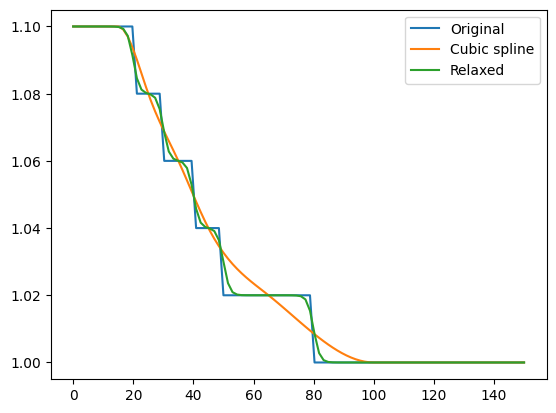

In [5]:
pt = np.linspace(0, 150, 100)

fig, ax = plt.subplots()
ax.plot(pt, ptweight.evaluate(pt), label="Original")
ax.plot(pt, ptweight_spline(pt), label="Cubic spline")
ax.plot(pt, ptweight_relaxed(pt), label="Relaxed")

ax.legend()

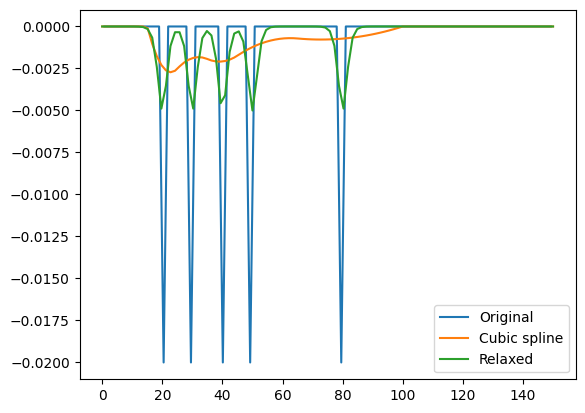

In [8]:
fig, ax = plt.subplots()
ax.plot(midpoints(pt), np.diff(ptweight.evaluate(pt)), label="Original")
# ptweight_spline isn't traceable, so no jax.vmap here
ax.plot(pt, np.vectorize(jax.grad(ptweight_spline))(pt), label="Cubic spline")
ax.plot(pt, jax.vmap(jax.grad(ptweight_relaxed))(pt), label="Relaxed")

ax.legend()